# Imports and Data


In [ ]:
!pip install -q trl
!pip install -q -U bitsandbytes
!pip install flash-attn --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from google.colab import userdata
from huggingface_hub import login
from peft import LoraConfig, get_peft_model, PeftModel

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score  # Для Match Rate
import re  # Для извлечения ключевых слов
import warnings

In [ ]:
from google.colab import drive
from pathlib import Path
import polars as pl
import os

drive.mount("/content/drive")

path_to_data = Path.cwd() / "drive" / "MyDrive" / "ColabNotebooks" / "Диплом"
os.chdir(path_to_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ["HF_TOKEN"] = userdata.get("hug")
login(os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Используется устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB"
    )
    print(f"Поддержка bfloat16: {torch.cuda.is_bf16_supported()}")

Используется устройство: cuda
GPU: NVIDIA L4
Память GPU: 22.16 GB
Поддержка bfloat16: True


In [ ]:
transitions_df = pd.read_parquet("./data/balanced_transitions.parquet")
cluster_labels_df = pd.read_parquet("./data/cluster_labels_df.parquet")
transitions_df = transitions_df.rename(columns={"target": "completion"})


all_valid_cluster_keyword_sets = [
    set(kw.strip().lower() for kw in str(keywords_str).split(","))
    for keywords_str in cluster_labels_df["keywords"]
]

all_valid_cluster_keyword_sets = [s for s in all_valid_cluster_keyword_sets if s]

In [ ]:
cluster_id_col = "cluster_L2"
all_valid_clusters_map = {
    row[cluster_id_col]: set(
        kw.strip().lower() for kw in str(row["keywords"]).split(",")
    )
    for index, row in cluster_labels_df.iterrows()
    if str(row["keywords"]).strip()
}

In [ ]:
def create_training_text_with_chat_template(row):
    messages = [
        {"role": "user", "content": str(row["prompt"])},
        {"role": "assistant", "content": str(row["completion"])},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,  # Важно для SFT
    )

In [ ]:
model_id = "meta-llama/Llama-3.1-8B-Instruct"

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(
    model_id, trust_remote_code=True, use_auth_token=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
transitions_df["text"] = transitions_df.apply(
    create_training_text_with_chat_template, axis=1
)
print("\nПример отформатированного текста (первый элемент):")
example_formatted_text = transitions_df["text"].iloc[0]
print(
    example_formatted_text[:1000] + "..."
    if len(example_formatted_text) > 1000
    else example_formatted_text
)

NameError: name 'tokenizer' is not defined

In [ ]:
# Разделение данных
train_df, test_df = train_test_split(
    transitions_df,
    test_size=0.2,
    random_state=42,
    stratify=transitions_df["completion"],
)
print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")

train_dataset = Dataset.from_pandas(train_df[["text"]])
eval_dataset = Dataset.from_pandas(test_df[["text", "prompt", "completion"]])

Размер обучающей выборки: 1959
Размер тестовой выборки: 490


KeyError: "None of [Index(['text'], dtype='object')] are in the [columns]"

In [ ]:
use_flash_attention = True
try:
    model_kwargs = {
        "torch_dtype": torch.bfloat16,
        "device_map": "auto",
        "trust_remote_code": True,
    }
    if (
        use_flash_attention
        and torch.cuda.is_available()
        and torch.cuda.is_bf16_supported()
    ):
        try:
            import flash_attn

            model_kwargs["attn_implementation"] = "flash_attention_2"
            print("Попытка загрузки модели с Flash Attention 2.")
        except ImportError:
            print("Пакет flash-attn не найден. Flash Attention 2 не будет использован.")
    elif use_flash_attention:
        print(
            "Flash Attention 2 не используется (GPU/bf16 не поддерживается или пакет не найден)."
        )

    model = AutoModelForCausalLM.from_pretrained(model_id, **model_kwargs)
    actual_attn_implementation = getattr(
        model.config, "_attn_implementation", "стандартная"
    )
    print(
        f"Модель {model_id} успешно загружена. Реализация внимания: {actual_attn_implementation}"
    )

except Exception as e:
    print(f"Ошибка загрузки модели {model_id}: {e}. Попытка запасного варианта.")

Попытка загрузки модели с Flash Attention 2.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Модель meta-llama/Llama-3.1-8B-Instruct успешно загружена. Реализация внимания: flash_attention_2


In [ ]:
peft_config = LoraConfig(
    r=64,
    lora_alpha=128,
    lora_dropout=0.05,  # Увеличено для большей регуляризации, можно настроить
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[  # Модули, специфичные для Llama архитектуры
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

In [ ]:
model.enable_input_require_grads()
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 167,772,160 || all params: 8,198,033,408 || trainable%: 2.0465


In [ ]:
unique_completion_strings = (
    transitions_df["completion"].unique().tolist() if not transitions_df.empty else []
)
print(f"Всего уникальных строк completion в датасете: {len(unique_completion_strings)}")

Всего уникальных строк completion в датасете: 246


In [ ]:
def extract_keywords_from_completion(completion_text):
    if not isinstance(completion_text, str):
        return []
    match = re.search(r"New cluster:\s*(.*)", completion_text, re.IGNORECASE)
    if match:
        keywords = [kw.strip().lower() for kw in match.group(1).split(",")]
        return [kw for kw in keywords if kw]
    return []


def jaccard_similarity_keywords(set1, set2):
    if not isinstance(set1, set):
        set1 = set(set1)
    if not isinstance(set2, set):
        set2 = set(set2)
    if not set1 and not set2:
        return 1.0
    if not set1 or not set2:
        return 0.0  # Исправлено: было s2 вместо set2
    return len(set1.intersection(set2)) / len(set1.union(set2))


def parse_previous_clusters_from_prompt(prompt_text_str):
    prev_clusters_keyword_sets = []
    for cluster_num in [1, 2]:
        match = re.search(
            rf"Cluster {cluster_num}:\s*([^\n]+)", prompt_text_str, re.IGNORECASE
        )
        if match and match.group(1):
            keywords = [kw.strip().lower() for kw in match.group(1).split(",")]
            prev_clusters_keyword_sets.append(set(kw for kw in keywords if kw))
    return prev_clusters_keyword_sets


def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids

In [ ]:
_trainer_instance = None


def compute_metrics_for_trainer(eval_preds):
    max_new_tokens_generation = 50
    max_prompt_len_for_tokenizer = (
        training_args.max_seq_length - max_new_tokens_generation - 5
    )

    generated_texts_for_metric = []
    original_prompts_for_metric = []
    true_completions_for_metric = [
        str(eval_dataset[i]["completion"]) for i in range(len(eval_dataset))
    ]

    target_device_for_inputs = (
        model.device
        if hasattr(model, "device") and model.device is not None
        else device
    )
    generation_batch_size = 16

    global _trainer_instance
    current_step_for_debug = (
        _trainer_instance.state.global_step
        if _trainer_instance and hasattr(_trainer_instance, "state")
        else "N/A"
    )
    print(
        f"\n[Шаг {current_step_for_debug}] Начало генерации для оценки ({len(eval_dataset)} примеров, батч: {generation_batch_size})..."
    )

    model.eval()
    original_padding_side = tokenizer.padding_side
    tokenizer.padding_side = "left"

    max_debug_prints_per_eval_call = 1
    debug_prints_done_this_call = 0

    for i in range(0, len(eval_dataset), generation_batch_size):
        batch_original_prompts_text = [
            str(eval_dataset[j]["prompt"])
            for j in range(i, min(i + generation_batch_size, len(eval_dataset)))
        ]
        original_prompts_for_metric.extend(batch_original_prompts_text)

        batch_prompts_for_generation = []
        for original_prompt_text in batch_original_prompts_text:
            messages = [{"role": "user", "content": original_prompt_text}]
            formatted_prompt = tokenizer.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            batch_prompts_for_generation.append(formatted_prompt)

        inputs = tokenizer(
            batch_prompts_for_generation,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_prompt_len_for_tokenizer,
        )
        inputs = {k: v.to(target_device_for_inputs) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens_generation,
                pad_token_id=tokenizer.eos_token_id,
                temperature=0.6,
                top_p=0.9,
                do_sample=True,
            )
        for j in range(outputs.shape[0]):
            generated_ids = outputs[j, inputs["input_ids"].shape[1] :]
            generated_text = tokenizer.decode(
                generated_ids, skip_special_tokens=True
            ).strip()
            generated_texts_for_metric.append(generated_text)

        if (
            i // generation_batch_size + 1
        ) % 10 == 0 or i + generation_batch_size >= len(eval_dataset):
            print(
                f"  [Шаг {current_step_for_debug}] Обработано {min(i + generation_batch_size, len(eval_dataset))}/{len(eval_dataset)} примеров для оценки..."
            )

    tokenizer.padding_side = original_padding_side
    print(f"[Шаг {current_step_for_debug}] Генерация для оценки завершена.")

    article_match_count = 0
    recall_exact_completion_count = 0
    jaccard_to_true_sum = 0

    threshold_same_as_previous = 0.8
    threshold_is_a_valid_cluster = 0.8

    for idx, pred_text in enumerate(generated_texts_for_metric):
        true_completion_text = true_completions_for_metric[idx]
        original_prompt_text = original_prompts_for_metric[idx]

        if pred_text == true_completion_text:
            recall_exact_completion_count += 1

        pred_keywords_set = set(extract_keywords_from_completion(pred_text))
        true_completion_keywords_set = set(
            extract_keywords_from_completion(true_completion_text)
        )
        jaccard_to_true_sum += jaccard_similarity_keywords(
            pred_keywords_set, true_completion_keywords_set
        )

        is_different_from_previous = True
        if pred_keywords_set:
            previous_cluster_keyword_sets = parse_previous_clusters_from_prompt(
                original_prompt_text
            )
            for prev_set in previous_cluster_keyword_sets:
                if not prev_set:
                    continue
                if (
                    jaccard_similarity_keywords(pred_keywords_set, prev_set)
                    >= threshold_same_as_previous
                ):
                    is_different_from_previous = False
                    break
        else:
            is_different_from_previous = False

        is_a_valid_known_cluster = False
        if (
            pred_keywords_set and all_valid_cluster_keyword_sets
        ):  # Проверяем, что all_valid_cluster_keyword_sets не пуст
            for canonical_set in all_valid_cluster_keyword_sets:
                if not canonical_set:
                    continue
                if (
                    jaccard_similarity_keywords(pred_keywords_set, canonical_set)
                    >= threshold_is_a_valid_cluster
                ):
                    is_a_valid_known_cluster = True
                    break

        if is_different_from_previous and is_a_valid_known_cluster:
            article_match_count += 1

        if debug_prints_done_this_call < max_debug_prints_per_eval_call:
            print(
                f"\n  --- [Шаг {current_step_for_debug}] Пример отладки метрик {debug_prints_done_this_call + 1} (Индекс в eval_dataset: {idx}) ---"
            )
            print(
                f"  исходный промпт пользователя (начало):\n{original_prompt_text[:200]}..."
            )
            print(f"  предсказанный текст: '{pred_text}'")
            print(f"  предсказанные ключевые слова: {pred_keywords_set}")
            print(f"  эталонный текст: '{true_completion_text}'")
            print(
                f"  ключевые слова предыдущих кластеров (из промпта): {parse_previous_clusters_from_prompt(original_prompt_text)}"
            )
            print(f"  отличается от предыдущих? {is_different_from_previous}")
            print(
                f"  является валидным известным кластером? {is_a_valid_known_cluster}"
            )
            print(
                f"  совпадение статьи? {is_different_from_previous and is_a_valid_known_cluster}"
            )
            debug_prints_done_this_call += 1

    total = len(generated_texts_for_metric)
    metrics = {
        "article_match_rate": article_match_count / total if total > 0 else 0,
        "recall_exact_completion": recall_exact_completion_count / total
        if total > 0
        else 0,
        "avg_jaccard_to_true": jaccard_to_true_sum / total if total > 0 else 0,
    }
    print(f"\n--- [Шаг {current_step_for_debug}] Итоговые результаты оценки ---")
    if total > 0 and generated_texts_for_metric and true_completions_for_metric:
        print(
            f"Пример предсказания (первый в eval_dataset): '{generated_texts_for_metric[0]}'"
        )
        print(
            f"Пример эталона (первый в eval_dataset): '{true_completions_for_metric[0]}'"
        )
    print(f"Рассчитанные метрики: {metrics}")
    return metrics

In [ ]:
training_args = SFTConfig(
    output_dir="./llama-kion-finetuned_v2",
    per_device_train_batch_size=20,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    learning_rate=2e-4,
    bf16=True,
    fp16=False,
    save_strategy="steps",
    save_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    gradient_checkpointing=True,
    logging_steps=25,
    warmup_ratio=0.1,
    optim="adamw_torch",
    report_to="wandb",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="article_match_rate",
    greater_is_better=True,
    dataset_text_field="text",
    max_seq_length=512,
    label_names=["labels"],
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics_for_trainer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    formatting_func=formatting_prompts_func,
)

_trainer_instance = trainer

Converting train dataset to ChatML:   0%|          | 0/1959 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/1959 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1959 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1959 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/490 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/490 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/490 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/490 [00:00<?, ? examples/s]

In [ ]:
print("Начало обучения...")
if len(train_dataset) > 0 and len(eval_dataset) > 0:
    trainer.train()
    print("Обучение завершено.")

    # Сохранение финальной модели (лучшей, если load_best_model_at_end=True)
    final_model_path = "./llama-kion-final-best_2"
    trainer.save_model(final_model_path)  # Сохраняет адаптеры LoRA
    tokenizer.save_pretrained(final_model_path)
    print(f"Лучшая модель сохранена в {final_model_path}")
else:
    print("Обучение пропущено из-за пустого обучающего или оценочного датасета.")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Начало обучения...


wandb: Currently logged in as: rkh01106 (phenomena) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Article Match Rate,Recall Exact Completion,Avg Jaccard To True
100,0.077900,0.454906,0.953061,0.169388,0.240703
200,0.056800,0.455128,0.991837,0.351020,0.405750
300,0.049600,0.454188,0.995918,0.385714,0.432564
400,0.047100,0.459271,0.993878,0.391837,0.439359



[Шаг 100] Начало генерации для оценки (490 примеров, батч: 16)...
  [Шаг 100] Обработано 160/490 примеров для оценки...
  [Шаг 100] Обработано 320/490 примеров для оценки...
  [Шаг 100] Обработано 480/490 примеров для оценки...
  [Шаг 100] Обработано 490/490 примеров для оценки...
[Шаг 100] Генерация для оценки завершена.

  --- [Шаг 100] Debug Metrics Example 1 (EvalDataset Index: 0) ---
  ORIGINAL USER PROMPT (начало):
The films or series I watched most recently are in the following clusters:

Cluster 1: война, отечественная война, отечественная, великая отечественная, летчики

Cluster 2: месть, драма, боевик, бои, ...
  PREDICTED TEXT: 'New cluster: советские, война, фронт, диверсии, немецкий'
  PREDICTED KEYWORDS: {'фронт', 'диверсии', 'советские', 'немецкий', 'война'}
  TRUE COMPLETION TEXT: 'New cluster: расследование, разруха, убийство, смоленск, советский детектив'
  PREVIOUS CLUSTERS KEYWORDS (из промпта): [{'летчики', 'великая отечественная', 'отечественная война', 'отечеств


--- Построение графиков результатов ---


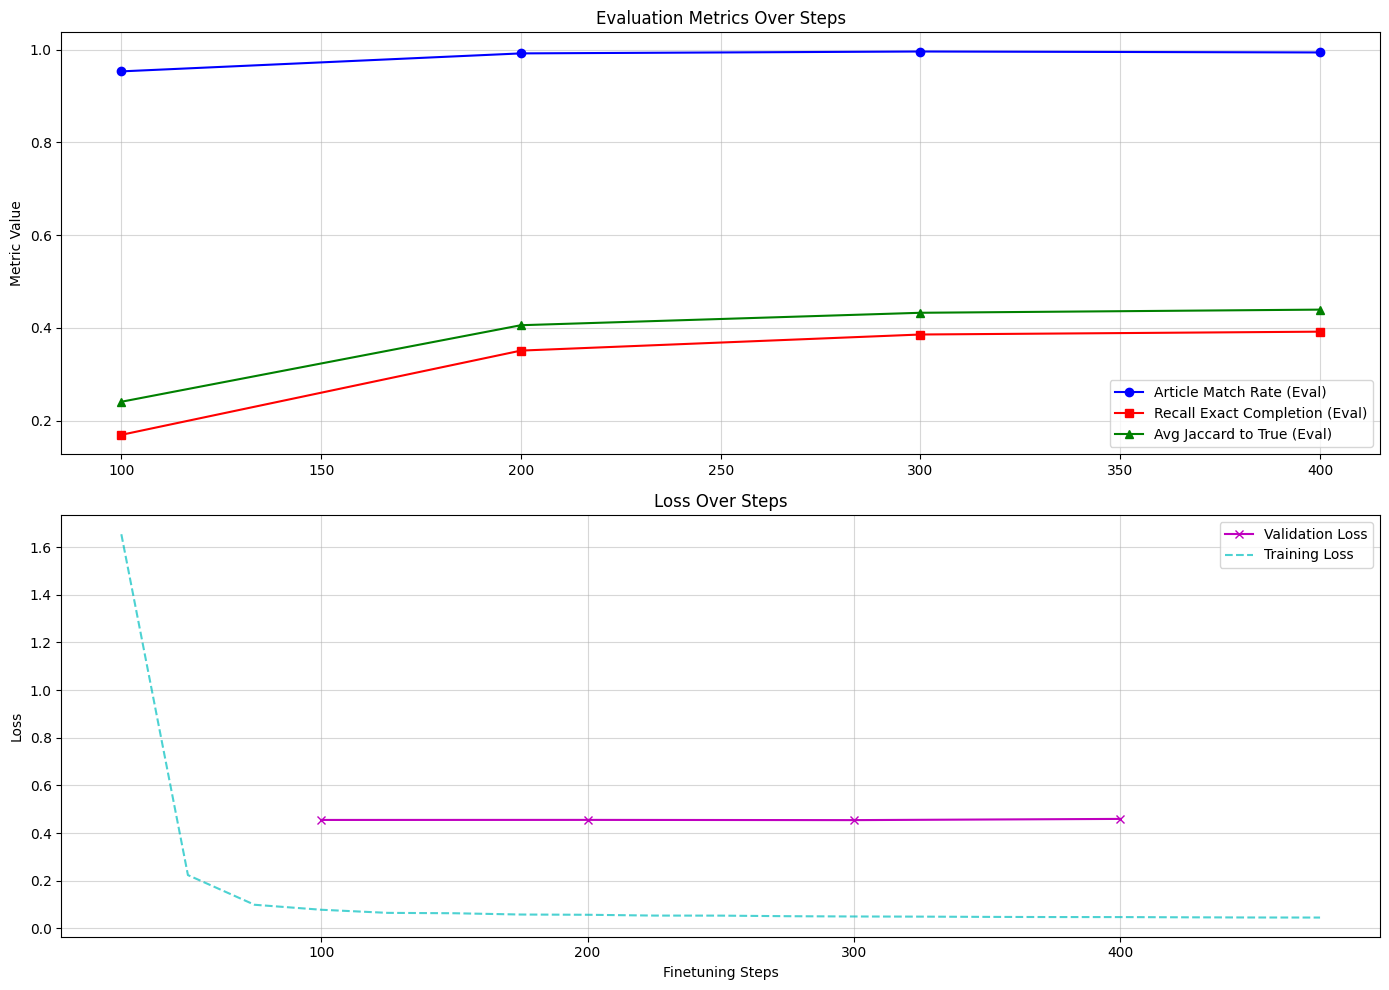


Финальные метрики (лучшей модели, сохраненной Trainer):
Лучший шаг: 300
  Article Match Rate: 0.9959
  Recall Exact Completion: 0.3857
  Avg Jaccard to True: 0.4326
  Validation Loss: 0.4542


In [ ]:
print("\n--- Построение графиков результатов ---")
if hasattr(trainer, "state") and trainer.state.log_history:
    log_df = pd.DataFrame(trainer.state.log_history)
    eval_log_df = log_df[
        log_df["eval_loss"].notna() | log_df["eval_article_match_rate"].notna()
    ].copy()
    eval_log_df.sort_values(by="step", inplace=True)
    if not eval_log_df.empty:
        plt.figure(figsize=(14, 10))
        plt.subplot(2, 1, 1)
        if "eval_article_match_rate" in eval_log_df.columns:
            plt.plot(
                eval_log_df["step"],
                eval_log_df["eval_article_match_rate"],
                "b-o",
                label="Article Match Rate (Eval)",
            )
        if "eval_recall_exact_completion" in eval_log_df.columns:
            plt.plot(
                eval_log_df["step"],
                eval_log_df["eval_recall_exact_completion"],
                "r-s",
                label="Recall Exact Completion (Eval)",
            )
        if "eval_avg_jaccard_to_true" in eval_log_df.columns:
            plt.plot(
                eval_log_df["step"],
                eval_log_df["eval_avg_jaccard_to_true"],
                "g-^",
                label="Avg Jaccard to True (Eval)",
            )
        plt.ylabel("Metric Value")
        plt.title("Evaluation Metrics Over Steps")
        plt.legend(loc="best")
        plt.grid(True, alpha=0.5)
        plt.subplot(2, 1, 2)
        if "eval_loss" in eval_log_df.columns:
            plt.plot(
                eval_log_df["step"],
                eval_log_df["eval_loss"],
                "m-x",
                label="Validation Loss",
            )
        train_loss_log_df = log_df[
            log_df["loss"].notna() & log_df["eval_loss"].isna()
        ].copy()
        train_loss_log_df.sort_values(by="step", inplace=True)
        if not train_loss_log_df.empty and "loss" in train_loss_log_df.columns:
            plt.plot(
                train_loss_log_df["step"],
                train_loss_log_df["loss"],
                "c--",
                label="Training Loss",
                alpha=0.7,
            )
        plt.xlabel("Finetuning Steps")
        plt.ylabel("Loss")
        plt.title("Loss Over Steps")
        plt.legend(loc="best")
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()
        print("\nФинальные метрики (лучшей модели, сохраненной Trainer):")
        if (
            trainer.state.best_model_checkpoint
            and "eval_article_match_rate" in eval_log_df.columns
        ):
            try:
                checkpoint_name_parts = trainer.state.best_model_checkpoint.split("-")
                if (
                    len(checkpoint_name_parts) > 1
                    and checkpoint_name_parts[-1].isdigit()
                ):
                    best_step = int(checkpoint_name_parts[-1])
                    best_eval_log = eval_log_df[eval_log_df["step"] == best_step]
                    if not best_eval_log.empty:
                        print(f"Лучший шаг: {best_step}")
                        print(
                            f"  Article Match Rate: {best_eval_log['eval_article_match_rate'].iloc[0]:.4f}"
                        )
                        print(
                            f"  Recall Exact Completion: {best_eval_log['eval_recall_exact_completion'].iloc[0]:.4f}"
                        )
                        print(
                            f"  Avg Jaccard to True: {best_eval_log['eval_avg_jaccard_to_true'].iloc[0]:.4f}"
                        )
                        print(
                            f"  Validation Loss: {best_eval_log['eval_loss'].iloc[0]:.4f}"
                        )
                    else:
                        print(
                            f"Не удалось найти лог для лучшего чекпоинта на шаге {best_step}."
                        )
                        if not eval_log_df.empty:
                            print(
                                f"Последние доступные метрики оценки: \n{eval_log_df.iloc[-1]}"
                            )
                else:
                    print(
                        f"Не удалось извлечь номер шага из {trainer.state.best_model_checkpoint}. Вывод последних метрик:"
                    )
                    if not eval_log_df.empty:
                        print(eval_log_df.iloc[-1])
            except Exception as e_plot:
                print(
                    f"Ошибка при извлечении метрик лучшей модели: {e_plot}. Вывод последних метрик:"
                )
                if not eval_log_df.empty:
                    print(eval_log_df.iloc[-1])
        elif not eval_log_df.empty:
            print(
                f"Информация о лучшем чекпоинте отсутствует или метрика {training_args.metric_for_best_model} не найдена. Вывод последних метрик:"
            )
            print(eval_log_df.iloc[-1])
        else:
            print("Информация о лучшем чекпоинте отсутствует и нет данных оценки.")
    else:
        print("Нет данных оценки для построения графика.")
else:
    print("История логирования недоступна или пуста для построения графиков.")

# Playground


In [ ]:
trainer.save_model("./best_model")  # Сохраняет адаптеры LoRA
tokenizer.save_pretrained("./best_tokenizer")

('./best_tokenizer/tokenizer_config.json',
 './best_tokenizer/special_tokens_map.json',
 './best_tokenizer/tokenizer.json')

In [ ]:
# Get model
path_to_saved_adapters = "./llama-kion-finetuned_v2/checkpoint-300"
model_id_for_tokenizer_and_base_model = "meta-llama/Llama-3.1-8B-Instruct"
use_flash_attention = True

# 6. Загрузка модели
model_load_kwargs = {
    "torch_dtype": torch.bfloat16,
    "device_map": "auto",
    "trust_remote_code": True,
}
if use_flash_attention and torch.cuda.is_available() and torch.cuda.is_bf16_supported():
    try:
        import flash_attn

        model_load_kwargs["attn_implementation"] = "flash_attention_2"
        print("Попытка загрузки модели с Flash Attention 2.")
    except ImportError:
        print("Пакет flash-attn не найден. Flash Attention 2 не будет использован.")
elif use_flash_attention:
    print("Flash Attention 2 не используется (не выполнены условия).")


if (
    path_to_saved_adapters
    and Path(path_to_saved_adapters).exists()
    and Path(path_to_saved_adapters, "adapter_config.json").exists()
):
    print(f"Загрузка адаптеров LoRA из: {path_to_saved_adapters}")

    try:
        loaded_tokenizer = AutoTokenizer.from_pretrained(path_to_saved_adapters)
        print(f"Токенизатор успешно загружен из {path_to_saved_adapters}.")
    except OSError:  # Если токенизатор не найден в папке адаптеров
        print(
            f"Токенизатор не найден в {path_to_saved_adapters}. Загрузка токенизатора из {model_id_for_tokenizer_and_base_model}."
        )
        loaded_tokenizer = AutoTokenizer.from_pretrained(
            model_id_for_tokenizer_and_base_model, trust_remote_code=True
        )
    except Exception as e_tok:
        print(
            f"Неожиданная ошибка загрузки токенизатора из {path_to_saved_adapters}: {e_tok}"
        )
        print(
            f"Попытка использовать токенизатор, определенный ранее (tokenizer_for_training)."
        )
        loaded_tokenizer = tokenizer_for_training  # Fallback

    if loaded_tokenizer.pad_token is None:
        loaded_tokenizer.pad_token = loaded_tokenizer.eos_token
    if loaded_tokenizer.chat_template is None and "llama3_chat_template" in globals():
        loaded_tokenizer.chat_template = llama3_chat_template
        print("Chat template был применен к загруженному токенизатору.")

    current_tokenizer_for_eval = (
        loaded_tokenizer  # Используем этот токенизатор для инференса
    )

    print(
        f"Загрузка базовой модели {model_id_for_tokenizer_and_base_model} для применения адаптеров..."
    )
    base_model_for_loading_inference = AutoModelForCausalLM.from_pretrained(
        model_id_for_tokenizer_and_base_model, **model_load_kwargs
    )
    print("Базовая модель для загрузки адаптеров создана.")

    # 3. Загружаем адаптеры LoRA поверх базовой модели
    loaded_model = PeftModel.from_pretrained(
        base_model_for_loading_inference, path_to_saved_adapters
    )
    print("Адаптеры LoRA успешно загружены поверх базовой модели.")

    loaded_model.eval()
    current_model_for_eval = loaded_model

Попытка загрузки модели с Flash Attention 2.
Загрузка адаптеров LoRA из: ./llama-kion-finetuned_v2/checkpoint-300
Токенизатор успешно загружен из ./llama-kion-finetuned_v2/checkpoint-300.
Загрузка базовой модели meta-llama/Llama-3.1-8B-Instruct для применения адаптеров...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Базовая модель для загрузки адаптеров создана.
Адаптеры LoRA успешно загружены поверх базовой модели.


In [ ]:
def generate_recommendation_with_chat_template(
    prompt_text, model_instance, tokenizer_instance
):
    model_instance.eval()
    target_device = (
        model_instance.device
        if hasattr(model_instance, "device") and model_instance.device is not None
        else device
    )
    orig_pad_side = tokenizer_instance.padding_side
    tokenizer_instance.padding_side = "left"
    messages = [{"role": "user", "content": str(prompt_text)}]
    formatted_prompt = tokenizer_instance.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    current_max_s_len = (
        training_args.max_seq_length if "training_args" in globals() else 512
    )
    max_prompt_len_inf = current_max_s_len - 50 - 5

    inputs = tokenizer_instance(
        formatted_prompt,
        return_tensors="pt",
        padding=False,
        truncation=True,
        max_length=max_prompt_len_inf,
    ).to(target_device)
    with torch.no_grad():
        outputs = model_instance.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.6,
            top_p=0.9,
            do_sample=True,
            num_beams=1,
            pad_token_id=tokenizer_instance.eos_token_id,
        )
    tokenizer_instance.padding_side = orig_pad_side
    return tokenizer_instance.decode(
        outputs[0, inputs["input_ids"].shape[1] :], skip_special_tokens=True
    ).strip()

In [ ]:
for i in range(min(2, len(test_df.sample(10)))):
    row = test_df.iloc[i]
    prediction = generate_recommendation_with_chat_template(
        row["prompt"], current_model_for_eval, current_tokenizer_for_eval
    )
    print(f"\n--- Загруженная модель: Пример {i + 1} ---")
    print(f"Prompt: {str(row['prompt'])}...\nПредсказание: {prediction}")


--- Загруженная модель: Пример 1 ---
Prompt: The films or series I watched most recently are in the following clusters:

Cluster 1: война, отечественная война, отечественная, великая отечественная, летчики

Cluster 2: месть, драма, боевик, бои, спорт

Each cluster is described with salient phrases or entity names.
With less than 30 words, generate a new and different cluster I will watch next
with highly specific salient phrases or entity names, with a prefix that says "New cluster: "
...
Предсказание: New cluster: расследование, разруха, убийство, смоленск, советский детектив

--- Загруженная модель: Пример 2 ---
Prompt: The films or series I watched most recently are in the following clusters:

Cluster 1: месть, драма, боевик, бои, спорт

Cluster 2: семейные, семейные ценности, ценности, комедия, дети

Each cluster is described with salient phrases or entity names.
With less than 30 words, generate a new and different cluster I will watch next
with highly specific salient phrases or


--- Анализ частоты генерации кластеров ---
  Анализ частот: Временно установлен tokenizer.padding_side = 'left' для генерации.
  Анализ частот: Обработано 80/490 примеров...
  Анализ частот: Обработано 160/490 примеров...
  Анализ частот: Обработано 240/490 примеров...
  Анализ частот: Обработано 320/490 примеров...
  Анализ частот: Обработано 400/490 примеров...
  Анализ частот: Обработано 480/490 примеров...
  Анализ частот: Обработано 490/490 примеров...
  Анализ частот: Восстановлен tokenizer.padding_side = 'right'.
  Количество предсказаний без извлеченных ключевых слов: 0
  Количество предсказаний, не сопоставленных с валидным кластером: 0


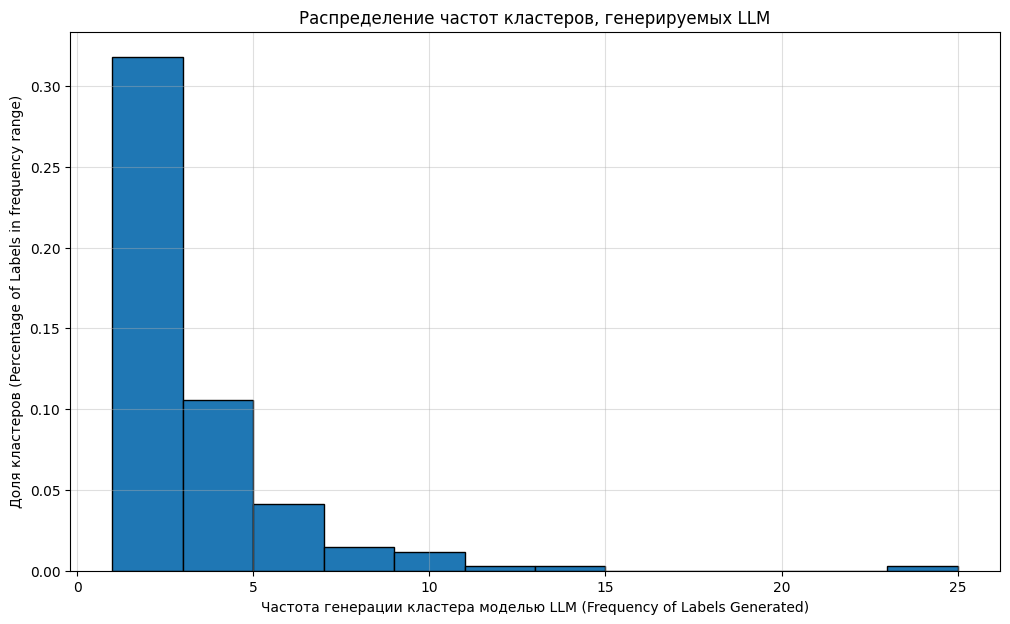


Топ-10 наиболее часто генерируемых валидных кластеров:
  ID Кластера: 114, Сгенерирован раз: 25, Ключевые слова: {'потеря', 'драма', 'любовь', 'индийская', 'одиночество'}
  ID Кластера: 49, Сгенерирован раз: 13, Ключевые слова: {'духовные', 'врач', 'драма', 'любовь', 'больница'}
  ID Кластера: 154, Сгенерирован раз: 11, Ключевые слова: {'напряжение', 'криминальный', 'ограбление', 'банка', 'опасность'}
  ID Кластера: 201, Сгенерирован раз: 9, Ключевые слова: {'приключения', 'мультфильм', 'животные', 'юмор', 'комедия'}
  ID Кластера: 155, Сгенерирован раз: 9, Ключевые слова: {'напряжение', 'триллер', 'расследование', 'игра', 'агент'}
  ID Кластера: 99, Сгенерирован раз: 9, Ключевые слова: {'спортивная драма', 'спортивная', 'соперничество', 'драма', 'спорт'}
  ID Кластера: 32, Сгенерирован раз: 9, Ключевые слова: {'советский', 'великая отечественная', 'отечественная война', 'отечественная', 'война'}
  ID Кластера: 220, Сгенерирован раз: 8, Ключевые слова: {'страна', 'волшебная страна', '

In [ ]:
from collections import Counter


def analyze_generated_cluster_frequencies(
    trained_model,
    tokenizer_instance,
    dataset_to_eval,
    valid_clusters_map,
    generation_bs=8,
    max_new_tok=50,
    temp=0.6,
    top_p_val=0.9,
):
    print("\n=== АНАЛИЗ ЧАСТОТЫ ГЕНЕРАЦИИ КЛАСТЕРОВ ===")
    trained_model.eval()
    target_device = (
        trained_model.device
        if hasattr(trained_model, "device") and trained_model.device is not None
        else device
    )

    all_predicted_cluster_ids = []

    # Сохраняем и временно меняем padding_side для генерации
    original_padding_side = tokenizer_instance.padding_side
    tokenizer_instance.padding_side = "left"
    print(
        f"Настройка токенизатора: padding_side изменен на '{tokenizer_instance.padding_side}' для генерации"
    )

    max_prompt_len = training_args.max_seq_length - max_new_tok - 5

    for i in range(0, len(dataset_to_eval), generation_bs):
        batch_original_prompts = [
            str(dataset_to_eval[j]["prompt"])
            for j in range(i, min(i + generation_bs, len(dataset_to_eval)))
        ]
        batch_prompts_for_gen = []
        for p_text in batch_original_prompts:
            messages = [{"role": "user", "content": p_text}]
            formatted_p = tokenizer_instance.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            batch_prompts_for_gen.append(formatted_p)

        inputs = tokenizer_instance(
            batch_prompts_for_gen,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_prompt_len,
        )
        inputs = {k: v.to(target_device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = trained_model.generate(
                **inputs,
                max_new_tokens=max_new_tok,
                pad_token_id=tokenizer_instance.eos_token_id,
                temperature=temp,
                top_p=top_p_val,
                do_sample=True,
            )

        for j_idx in range(outputs.shape[0]):
            generated_ids = outputs[j_idx, inputs["input_ids"].shape[1] :]
            pred_text = tokenizer_instance.decode(
                generated_ids, skip_special_tokens=True
            ).strip()
            pred_keywords_set = set(extract_keywords_from_completion(pred_text))

            if not pred_keywords_set:
                all_predicted_cluster_ids.append("INVALID_OR_EMPTY_PREDICTION")
                continue

            # Сопоставляем с валидными кластерами
            best_match_id = None
            max_similarity = -1.0
            current_threshold_is_a_valid_cluster = 0.5

            for canonical_id, canonical_set in valid_clusters_map.items():
                if not canonical_set:
                    continue
                similarity = jaccard_similarity_keywords(
                    pred_keywords_set, canonical_set
                )
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_match_id = canonical_id

            if max_similarity >= current_threshold_is_a_valid_cluster:
                all_predicted_cluster_ids.append(best_match_id)
            else:
                all_predicted_cluster_ids.append("NO_VALID_MATCH")

        if (i // generation_bs + 1) % 10 == 0 or i + generation_bs >= len(
            dataset_to_eval
        ):
            print(
                f"Прогресс обработки: {min(i + generation_bs, len(dataset_to_eval))}/{len(dataset_to_eval)} примеров"
            )

    tokenizer_instance.padding_side = original_padding_side
    print(
        f"Настройка токенизатора: padding_side восстановлен на '{tokenizer_instance.padding_side}'"
    )

    cluster_frequencies = Counter(all_predicted_cluster_ids)

    num_invalid_or_empty = cluster_frequencies.pop("INVALID_OR_EMPTY_PREDICTION", 0)
    num_no_valid_match = cluster_frequencies.pop("NO_VALID_MATCH", 0)

    print(f"\nРезультаты анализа:")
    print(f"• Предсказания без ключевых слов: {num_invalid_or_empty}")
    print(f"• Предсказания без совпадений с кластерами: {num_no_valid_match}")
    print(f"• Валидные предсказания: {sum(cluster_frequencies.values())}")

    if not cluster_frequencies:
        print("Не найдено ни одного валидного предсказания. График не будет построен.")
        return

    # Данные для гистограммы: список частот (сколько раз каждый кластер был предсказан)
    frequencies_list = list(cluster_frequencies.values())

    plt.figure(figsize=(12, 7))
    counts, bin_edges = np.histogram(
        frequencies_list,
        bins=min(50, len(set(frequencies_list)) if frequencies_list else 1),
        density=True,
    )
    plt.bar(
        bin_edges[:-1],
        counts,
        width=np.diff(bin_edges),
        edgecolor="black",
        align="edge",
    )

    plt.xlabel("Частота генерации кластера моделью LLM")
    plt.ylabel("Доля кластеров")
    plt.title("Распределение частот генерируемых кластеров")
    plt.grid(True, alpha=0.4)
    plt.show()

    print(f"\nТОП-10 наиболее часто генерируемых кластеров:")
    for rank, (cluster_id, count) in enumerate(cluster_frequencies.most_common(10), 1):
        keywords_for_id = all_valid_clusters_map.get(
            cluster_id, "Неизвестные ключевые слова"
        )
        print(
            f"{rank:2d}. Кластер {cluster_id}: {count} раз | Ключевые слова: {keywords_for_id}"
        )


# Вызов функции анализа после обучения и загрузки лучшей модели
if (
    "trainer" in locals()
    and trainer is not None
    and hasattr(trainer, "model")
    and trainer.model is not None
    and all_valid_clusters_map
):
    analyze_generated_cluster_frequencies(
        trainer.model, tokenizer, eval_dataset, all_valid_clusters_map
    )
else:
    print("Анализ частоты генерации пропущен: модель или карта кластеров недоступны")

In [ ]:
def generate_recommendation_with_chat_template(
    prompt_text, model_instance, tokenizer_instance
):
    model_instance.eval()
    target_device_for_inputs = (
        model_instance.device
        if hasattr(model_instance, "device") and model_instance.device is not None
        else device
    )
    original_padding_side = tokenizer_instance.padding_side
    tokenizer_instance.padding_side = "left"
    messages = [{"role": "user", "content": str(prompt_text)}]
    formatted_prompt_for_generation = tokenizer_instance.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    max_prompt_len_for_tokenizer_inf = training_args.max_seq_length - 50 - 5
    inputs = tokenizer_instance(
        formatted_prompt_for_generation,
        return_tensors="pt",
        padding=False,
        truncation=True,
        max_length=max_prompt_len_for_tokenizer_inf,
    )
    inputs = {k: v.to(target_device_for_inputs) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model_instance.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.6,
            top_p=0.9,
            do_sample=True,
            num_beams=1,
            pad_token_id=tokenizer_instance.eos_token_id,
        )
    tokenizer_instance.padding_side = original_padding_side
    prediction = tokenizer_instance.decode(
        outputs[0, inputs["input_ids"].shape[1] :], skip_special_tokens=True
    )
    return prediction.strip()


if (
    "test_df" in locals()
    and not test_df.empty
    and "prompt" in test_df.columns
    and "completion" in test_df.columns
    and "trainer" in locals()
    and trainer is not None
    and hasattr(trainer, "model")
    and trainer.model is not None
):
    print(
        "\n--- Примеры генерации рекомендаций (с использованием лучшей обученной модели и Chat Template для промпта) ---"
    )
    model_to_test = trainer.model
    num_examples_to_test = min(5, len(test_df))
    for i in range(num_examples_to_test):
        row = test_df.iloc[i]
        prediction = generate_recommendation_with_chat_template(
            row["prompt"], model_to_test, tokenizer
        )
        pred_keywords = extract_keywords_from_completion(prediction)
        true_keywords = extract_keywords_from_completion(str(row["completion"]))
        similarity = jaccard_similarity_keywords(set(pred_keywords), set(true_keywords))
        print(f"\n--- Пример {i + 1} ---")
        print(f"Prompt (original user content): {str(row['prompt'])[:200]}...")
        print(f"Истинный ответ: {str(row['completion'])}")
        print(f"Предсказание: {prediction}")
        print(f"Ключ. слова (ист.): {true_keywords}")
        print(f"Ключ. слова (пред.): {pred_keywords}")
        print(f"Схожесть Жаккара: {similarity:.3f}")
        print(
            f"Точное совпадение: {'✓' if prediction == str(row['completion']) else '✗'}"
        )
        print("-" * 80)
else:
    print("Тестирование пропущено.")

In [ ]:
if (
    "test_df" in locals()
    and not test_df.empty
    and "prompt" in test_df.columns
    and "completion" in test_df.columns
    and "trainer" in locals()
    and trainer is not None
    and hasattr(trainer, "model")
    and trainer.model is not None
):
    print(
        "\n--- Примеры генерации рекомендаций (с использованием лучшей обученной модели и Chat Template для промпта) ---"
    )
    model_to_test = trainer.model
    num_examples_to_test = min(5, len(test_df))
    for i in range(num_examples_to_test):
        row = test_df.iloc[i]
        prediction = generate_recommendation_with_chat_template(
            row["prompt"], model_to_test, tokenizer
        )

        pred_keywords = extract_keywords_from_completion("New cluster: " + prediction)
        true_keywords = extract_keywords_from_completion(str(row["completion"]))
        similarity = jaccard_similarity_keywords(pred_keywords, true_keywords)

        print(f"\n--- Пример {i + 1} ---")
        print(f"Prompt (original user content): {str(row['prompt'])}...")
        print(f"Истинный ответ: {str(row['completion'])}")
        print(f"Предсказание: {prediction}")
        print(f"Ключ. слова (ист.): {true_keywords}")
        print(f"Ключ. слова (пред.): {pred_keywords}")
        print(f"Схожесть Жаккара: {similarity:.3f}")
        print(
            f"Точное совпадение: {'✓' if prediction == str(row['completion']) else '✗'}"
        )
        print("-" * 80)
else:
    print("Тестирование пропущено.")

In [ ]:
print("\n--- Информация о сохранении модели ---")
if (
    "trainer" in locals()
    and trainer is not None
    and hasattr(trainer, "state")
    and trainer.state.best_model_checkpoint
):
    print(
        f"Лучшая модель (адаптеры LoRA) и токенизатор сохранены в директории чекпоинта: {trainer.state.best_model_checkpoint}"
    )
    print(
        f"А также копия была сохранена в: {training_args.output_dir}/best_model_adapters (если обучение завершилось успешно)"
    )
else:
    print("Модель не была сохранена или информация о лучшем чекпоинте отсутствует.")
print("\nСкрипт завершен.")


--- Информация о сохранении модели ---
Лучшая модель (адаптеры LoRA) и токенизатор сохранены в директории чекпоинта: ./llama-kion-finetuned_v2/checkpoint-300
А также копия была сохранена в: ./llama-kion-finetuned_v2/best_model_adapters (если обучение завершилось успешно)

Скрипт завершен.
